In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
import geopandas as gpd
from scipy.stats import linregress
from scipy.stats import norm
import seaborn as sns
import colorcet as cc
import pandas as pd

In [86]:
jan = gpd.read_file("./Data/df_comarques_total.gpkg")
javi = pd.read_csv("./Data/javi.csv", sep=",", encoding="utf-8-sig")
german_df = pd.read_csv("./Data/german.csv", sep=",", encoding="utf-8-sig")
eulalia = pd.read_csv("./Data/eulalia.csv", sep=",", encoding="utf-8-sig")
ale_df = pd.read_csv("./Data/ale.csv", sep=",", encoding="utf-8-sig")

javi_df = javi[["comarca", "porc_norm"]]





In [96]:
def normalize_percentile_trim(df, col, low_pct=0, high_pct=100):
    values = df[col].astype(float).values

    if len(values) < 3:
        raise ValueError("Need at least 3 values for percentile trimming.")

    low = np.percentile(values, low_pct)
    high = np.percentile(values, high_pct)
    if low == high:
        raise ValueError("Percentile bounds collapsed to a single value.")

    # Clip values to percentile range
    clipped = np.clip(values, low, high)

    # Min-max normalize to 0-1
    scale = high
    if scale == 0:
        scale = 1e-9

    normalized = np.clip(clipped / scale, 0, 1)

    norm_col = f"{col}_norm"
    df[norm_col] = normalized

    return df[["comarca", norm_col]]

jan_total = normalize_percentile_trim(jan, "total_coverage", high_pct = 98)
jan_ohca = normalize_percentile_trim(jan, "ohca rel")

jan_df = jan_total.merge(
    jan_ohca[['comarca', 'ohca rel_norm']],  # only the column you want
    on='comarca',
    how='left'  # keep all rows from jan_df
)
jan_df

,comarca,total_coverage_norm,ohca rel_norm
0,alt camp,0.285424,0.486476
1,alt emporda,0.384987,0.537276
2,alt penedes,0.388509,0.478480
3,alt urgell,0.594115,0.825703
4,alta ribagorca,0.936370,0.438536
5,anoia,0.621228,0.527350
6,aran,0.652258,0.357552
7,bages,0.267178,0.661825
8,baix camp,0.203525,0.458543
9,baix ebre,0.319283,0.729196


In [148]:
"""
We compute a very simple risk index related to our data. We assume that vehicles have a 1 risk as we never know if we
could be close to them or not.
"""

access_map = {
'High': 0,
'Medium': 0.5,
'Low': 1,
'Vehicle': 1
}

# Map the values
eulalia['access_value'] = eulalia['accessibilitat'].map(access_map)

df_grouped = eulalia.groupby('comarca').agg(
accessibility_sum=('access_value', 'sum'),
count=('access_value', 'count')
).reset_index()
df_grouped['acces norm'] = df_grouped['accessibility_sum'] / df_grouped['count']


eulalia_df = df_grouped[["comarca", "acces norm"]]
eulalia_df = normalize_percentile_trim(eulalia_df,"acces norm")

/var/folders/_r/lv31y_xx5hzfyhbw22ddz7gr0000gn/T/ipykernel_8076/586664854.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[norm_col] = normalized


In [149]:
import unicodedata

def normalize(text):
    if isinstance(text, str):
        text = text.lower().strip()
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        text = text.replace('-', ' ').replace("'", "").replace("’", "")
        if text == "val daran":
            return "aran"
        return text
    return text

jan_df['comarca'] = jan_df['comarca'].apply(normalize)
javi_df['comarca'] = javi_df['comarca'].apply(normalize)
eulalia_df['comarca'] = eulalia_df['comarca'].apply(normalize)
german_df['comarca'] = german_df['comarca'].apply(normalize)
ale_df['comarca'] = ale_df['comarca'].apply(normalize)

name_map = dict(zip(javi_df["comarca"], javi["comarca"]))

In [150]:
"""
We eliminate the llucanes comarca, and continue.
"""
javi_df = javi_df[javi_df['comarca'] != 'llucanes']
jan_df = jan_df[jan_df['comarca'] != 'llucanes']
german_df = german_df[german_df['comarca'] != 'llucanes']
eulalia_df = eulalia_df[eulalia_df['comarca'] != 'llucanes']
ale_df = ale_df[ale_df['comarca'] != 'llucanes']

final = jan_df.merge(javi_df, on='comarca', how='outer')
final = final.merge(german_df, on='comarca', how='outer')
final = final.merge(eulalia_df, on='comarca', how='outer')
final = final.merge(ale_df, on='comarca', how='outer')

#We invert the total coverage norm so that a 1 indicates a higher risk
final["total_coverage_norm"] = 1-final["total_coverage_norm"]
final

,comarca,total_coverage_norm,ohca rel_norm,porc_norm,indice_pca_norm,acces norm_norm,indice_dist
0,alt camp,0.714576,0.486476,0.287210,0.537578,0.592171,0.636695
1,alt emporda,0.615013,0.537276,0.238623,0.469938,0.920784,0.701908
2,alt penedes,0.611491,0.478480,0.185105,0.425215,0.542790,0.762200
3,alt urgell,0.405885,0.825703,0.492180,0.566693,0.443346,0.026090
4,alta ribagorca,0.063630,0.438536,0.310331,0.344013,0.252660,0.126680
5,anoia,0.378772,0.527350,0.208685,0.366418,0.673949,0.679113
6,aran,0.347742,0.357552,0.050329,0.231923,0.293411,0.479367
7,bages,0.732822,0.661825,0.361998,0.358903,0.669842,0.623933
8,baix camp,0.796475,0.458543,0.206711,0.344675,0.525022,0.636032
9,baix ebre,0.680717,0.729196,0.489898,0.810657,0.497777,0.468434


In [151]:
"""
We rename the columns and map the comarca names to original names
"""
rename_map = {
    "total_coverage_norm" : "cov_risk",
    "ohca rel_norm": "ohca_risk",
    "porc_norm": "age_risk",
    "indice_pca_norm": "poverty_risk",
    "acces norm_norm": "acessibility_risk",
    "indice_dist": "distance_risk"
}

final = final.rename(columns=rename_map)

valid_comarques = set(final["comarca"])

# Keep only the keys that match comarques in `final`
name_map = {k: v for k, v in name_map.items() if k in valid_comarques}

final["comarca"] = final["comarca"].map(name_map)
final

,comarca,cov_risk,ohca_risk,age_risk,poverty_risk,acessibility_risk,distance_risk
0,Alt Camp,0.714576,0.486476,0.287210,0.537578,0.592171,0.636695
1,Alt Empordà,0.615013,0.537276,0.238623,0.469938,0.920784,0.701908
2,Alt Penedès,0.611491,0.478480,0.185105,0.425215,0.542790,0.762200
3,Alt Urgell,0.405885,0.825703,0.492180,0.566693,0.443346,0.026090
4,Alta Ribagorça,0.063630,0.438536,0.310331,0.344013,0.252660,0.126680
5,Anoia,0.378772,0.527350,0.208685,0.366418,0.673949,0.679113
6,Val d'Aran,0.347742,0.357552,0.050329,0.231923,0.293411,0.479367
7,Bages,0.732822,0.661825,0.361998,0.358903,0.669842,0.623933
8,Baix Camp,0.796475,0.458543,0.206711,0.344675,0.525022,0.636032
9,Baix Ebre,0.680717,0.729196,0.489898,0.810657,0.497777,0.468434


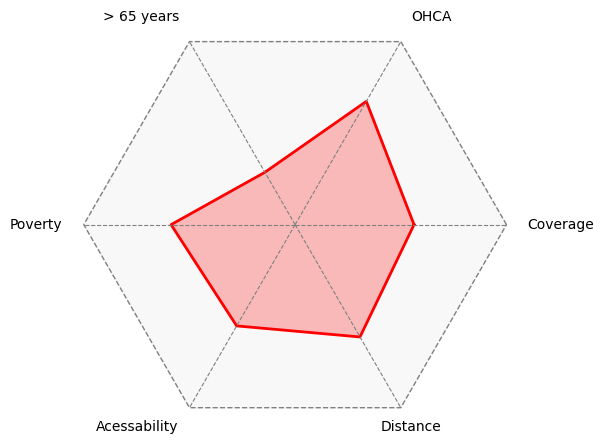

In [152]:
"""
The following function plots a spyder hexagonal plot showcasing the risk associated to every comarca.
"""

risks = ["cov_risk", "ohca_risk", "age_risk", "poverty_risk", "acessibility_risk", "distance_risk"]
labels = ["Coverage", "OHCA", "> 65 years", "Poverty", "Acessability", "Distance"]


def fifa_plot(row_name, risks, labels):
    row = final[final["comarca"] == row_name]
    num_vars = len(labels)
    row_values = row[risks].values.flatten().tolist()
    

    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    values = np.array(row_values)

    # Create a polygon
    x = np.cos(angles) * values
    y = np.sin(angles) * values
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    
    # Outer polygon reference
    x_outer = np.cos(angles)
    y_outer = np.sin(angles)
    x_outer = np.append(x_outer, x_outer[0])
    y_outer = np.append(y_outer, y_outer[0])
    
    fig, ax = plt.subplots(figsize=(6,6))

    # Draw polygons
    ax.plot(x_outer, y_outer, color='grey', linewidth=1, linestyle='--')
    ax.fill(x_outer, y_outer, color='grey', alpha=0.05)
    ax.plot(x, y, color='red', linewidth=2)
    ax.fill(x, y, color='red', alpha=0.25)
    
    # Draw radial lines
    for angle in angles:
        ax.plot([0, np.cos(angle)], [0, np.sin(angle)], color='grey', linewidth=0.8, linestyle='--')
    
    # Label each vertex slightly outside
    for i in range(num_vars):
        angle = angles[i]
        x_text = np.cos(angle) * 1.1 
        y_text = np.sin(angle) * 1.1

        ha = 'center'
        va = 'center'
        if -np.pi/2 < angle < np.pi/2:
            ha = 'left'
        elif np.pi/2 < angle < 3*np.pi/2:
            ha = 'right'
    
        if 0 < angle < np.pi:
            va = 'bottom'
        elif -np.pi < angle < 0:
            va = 'top'
    
        ax.text(x_text, y_text, labels[i], ha=ha, va=va, fontsize=10)
    
    ax.set_aspect('equal')
    ax.axis('off')
    #plt.title("Polygon Radar Plot for Urgell", fontsize=14)
    plt.show()

fifa_plot("Urgell", risks, labels)

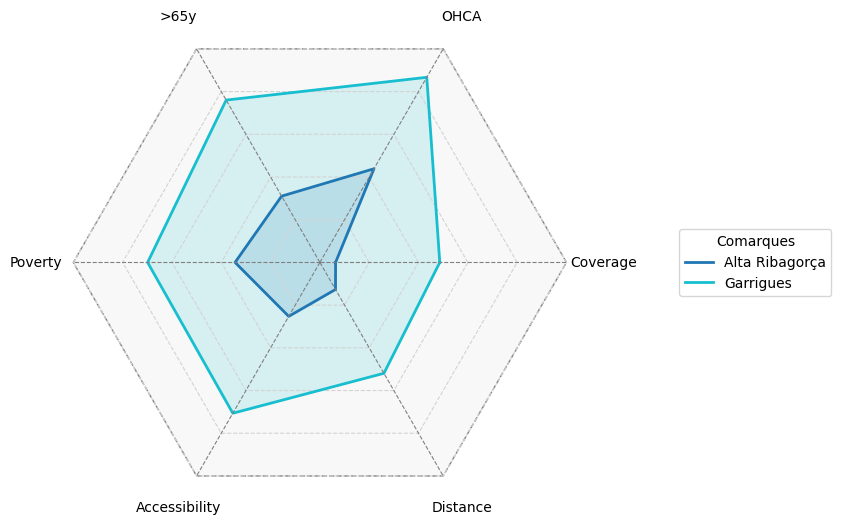

In [156]:
def fifa_multi(final, row_names, risks, labels, colors=None):
    num_vars = len(labels)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    # Outer reference polygon
    x_outer = np.cos(angles)
    y_outer = np.sin(angles)
    x_outer = np.append(x_outer, x_outer[0])
    y_outer = np.append(y_outer, y_outer[0])

    # Prepare colors
    if colors is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(row_names)))

    fig, ax = plt.subplots(figsize=(7,7))

    # Draw outer polygon
    ax.plot(x_outer, y_outer, color='grey', linewidth=1, linestyle='--')
    ax.fill(x_outer, y_outer, color='grey', alpha=0.05)

    # --- POLYGON GRID LINES (every 0.2) ---
    grid_vals = np.arange(0.2, 1.01, 0.2)
    
    for r in grid_vals:
        xs = np.cos(angles) * r
        ys = np.sin(angles) * r
    
        # Close polygon
        xs = np.append(xs, xs[0])
        ys = np.append(ys, ys[0])
    
        # Draw polygon grid
        ax.plot(xs, ys, color='lightgrey', linewidth=0.8, linestyle='--')

    # --- Plot each comarca polygon ---
    for idx, row_name in enumerate(row_names):
        row = final[final["comarca"] == row_name]

        if row.empty:
            print(f"Warning: '{row_name}' not found in dataframe.")
            continue

        vals = row[risks].values.flatten().astype(float)

        # Convert to polygon coords
        x = np.cos(angles) * vals
        y = np.sin(angles) * vals
        x = np.append(x, x[0])
        y = np.append(y, y[0])

        ax.plot(x, y, color=colors[idx], linewidth=2, label=row_name)
        ax.fill(x, y, color=colors[idx], alpha=0.15)

    # --- Draw radial lines ---
    for angle in angles:
        ax.plot([0, np.cos(angle)], [0, np.sin(angle)], 
                color='grey', linewidth=0.8, linestyle='--')

    # --- Labels slightly outside the polygon ---
    for i in range(num_vars):
        angle = angles[i]
        x_text = np.cos(angle) * 1.15
        y_text = np.sin(angle) * 1.15
        ax.text(x_text, y_text, labels[i], ha='center', va='center', fontsize=10)

    ax.set_aspect('equal')
    ax.axis('off')

    # Legend on right side
    ax.legend(
        loc='center left',
        bbox_to_anchor=(1.15, 0.5),
        title="Comarques"
    )

    plt.show()

risks = ["cov_risk", "ohca_risk", "age_risk", "poverty_risk", "acessibility_risk", "distance_risk"]
labels = ["Coverage", "OHCA", ">65y", "Poverty", "Accessibility", "Distance"]

comarques_to_plot = ["Alta Ribagorça", "Garrigues"]

fifa_multi(final, comarques_to_plot, risks, labels)

In [153]:
"""
We finally plot a spiral bar plot with all risk per comarca, which would showcase the diversity and how some comarcas
have a worse risk plus AED coverage total. 
"""
risks = ["acessibility_risk", "distance_risk", "ohca_risk", "poverty_risk", "age_risk", "cov_risk"]
labels = ["Acessability", "Distance", "OHCA", "Poverty", "> 65 years", "Coverage"]


final["total_risk"] = final[risks].sum(axis=1)
final_sorted = final.sort_values("total_risk", ascending=True)
risk_values = final_sorted[risks].values
comarques = final_sorted["comarca"].values
num_comarques = len(comarques)

theta = np.linspace(0, 2*np.pi, num_comarques, endpoint=False)
width = 2*np.pi/num_comarques * 0.9

colors = plt.cm.viridis(np.linspace(0, 1, len(risks)))

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))

ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.spines['polar'].set_visible(False)

ax.set_theta_zero_location("E")  # 0° horizontal right
ax.set_theta_direction(1)        # counterclockwise

for i, risk in enumerate(risks):
    bottom = risk_values[:, :i].sum(axis=1) if i > 0 else None
    ax.bar(theta, risk_values[:, i], width=width, bottom=bottom,
           color=colors[i], edgecolor='k', alpha=0.8, label=risk)
"""
# Add original labels at bar tips
for i, angle in enumerate(theta):
    r_end = risk_values[i, :].sum() + 0.05  # slightly beyond bar tip
    ax.text(angle, r_end, comarques[i],
            rotation=0,   # original labels horizontal
            ha='center', va='center',
            fontsize=8)
"""
# Add labels along bars with flipping on left side
offset = 0.2  
for i, angle in enumerate(theta):
    r_end = risk_values[i, :].sum() + offset
    
    angle_deg = np.degrees(angle)
    
    # Flip text if on left side
    if 90 < angle_deg < 270:
        rotation = angle_deg + 180
        ha = 'right'
    else:
        rotation = angle_deg
        ha = 'left'
    
    ax.text(angle, r_end, comarques[i],
            rotation=rotation,
            rotation_mode='anchor',
            ha=ha, va='center', fontsize=8)
    
#ax.set_title("Stacked Risk per Comarca", fontsize=14)
ax.legend(title="Risks", labels=labels, loc="upper right", bbox_to_anchor=(1.1, 0.9))
plt.savefig("./plots/total.png")
plt.close()